<h2><i><b> PYTORCH - Training on MNIST Dataset </h3>

---



CODE BLOCK: 1

### Imports <hr>

In [1]:
# Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary

# Loading classes from py files
from model import Net
from utils import Transform, Utility

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Initialization

In [2]:
# creating class objects
get_transform = Transform()
get_utilitites= Utility()

# variable for model and training
batch_size = 512
num_epochs = 15

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

CODE BLOCK: 2

##### Check device support CPU/GPU <hr> 

In [3]:
# CODE MOVED TO UTILS.PY

# CUDA?
device = Utility.set_cuda_if_available()
print(f'Device available for the script - {device}')

CUDA Available? <function is_available at 0x7f2a1c3357e0>
Device available for the script - cuda


CODE BLOCK: 3

##### Create transforms to apply to dataset <hr>


In [4]:
# CODE MOVED TO UTILS.PY

CODE BLOCK: 4

##### Create train/test dataset with transforms <hr>

In [5]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=get_transform.train_transform())
test_data = datasets.MNIST('../data', train=False, download=True, transform=get_transform.test_transform())

CODE BLOCK: 5

Create Batch loader for train/test dataset <hr>

In [6]:
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [7]:
# Analyze the first batch of 512 images
images, labels = next(iter(train_loader))
print(f'Shape of the batch - {images.shape}')
print(f'Total images in the batch - {len(labels)}')

Shape of the batch - torch.Size([512, 1, 28, 28])
Total images in the batch - 512


CODE BLOCK: 6

View sample images from the train loader 

---



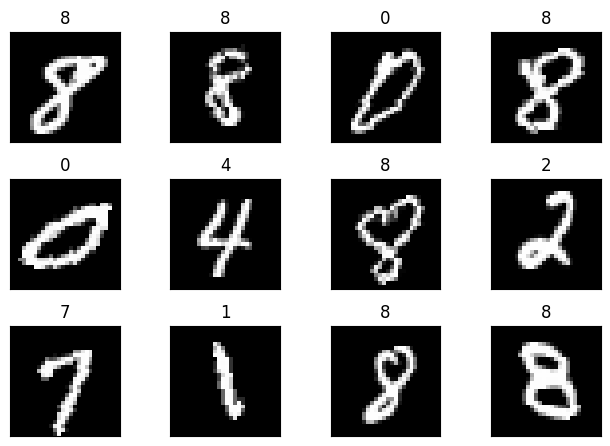

In [8]:
# CODE MOVED TO UTILS.PY

get_utilitites.plot_grid(train_loader)

CODE BLOCK: 7

Defining the Model architecture

---



In [9]:
# CODE MOVED TO MODELS.PY

# New line added for model summary
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


CODE BLOCK: 8

Declare variables

In [10]:
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 8

Define the TRAIN + TEST Functions

---


In [11]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 9

Model training

---


In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=11, gamma=0.1, verbose=True)

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.3954 Batch_id=117 Accuracy=43.09: 100%|██████████| 118/118 [00:31<00:00,  3.72it/s]


Test set: Average loss: 0.3379, Accuracy: 8997/10000 (89.97%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1512 Batch_id=117 Accuracy=92.72: 100%|██████████| 118/118 [00:23<00:00,  5.04it/s]


Test set: Average loss: 0.0946, Accuracy: 9684/10000 (96.84%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1951 Batch_id=117 Accuracy=96.19: 100%|██████████| 118/118 [00:23<00:00,  5.07it/s]


Test set: Average loss: 0.0708, Accuracy: 9777/10000 (97.77%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0924 Batch_id=117 Accuracy=96.93: 100%|██████████| 118/118 [00:23<00:00,  5.05it/s]


Test set: Average loss: 0.0527, Accuracy: 9819/10000 (98.19%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0635 Batch_id=117 Accuracy=97.41: 100%|██████████| 118/118 [00:25<00:00,  4.69it/s]


Test set: Average loss: 0.0525, Accuracy: 9826/10000 (98.26%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0362 Batch_id=117 Accuracy=97.75: 100%|██████████| 118/118 [00:24<00:00,  4.81it/s]


Test set: Average loss: 0.0444, Accuracy: 9856/10000 (98.56%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.1071 Batch_id=117 Accuracy=98.05: 100%|██████████| 118/118 [00:23<00:00,  5.04it/s]


Test set: Average loss: 0.0356, Accuracy: 9893/10000 (98.93%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0157 Batch_id=117 Accuracy=98.19: 100%|██████████| 118/118 [00:23<00:00,  5.00it/s]


Test set: Average loss: 0.0394, Accuracy: 9876/10000 (98.76%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0208 Batch_id=117 Accuracy=98.38: 100%|██████████| 118/118 [00:23<00:00,  5.11it/s]


Test set: Average loss: 0.0313, Accuracy: 9907/10000 (99.07%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0274 Batch_id=117 Accuracy=98.40: 100%|██████████| 118/118 [00:23<00:00,  5.07it/s]


Test set: Average loss: 0.0286, Accuracy: 9916/10000 (99.16%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0180 Batch_id=117 Accuracy=98.54: 100%|██████████| 118/118 [00:23<00:00,  5.06it/s]


Test set: Average loss: 0.0273, Accuracy: 9916/10000 (99.16%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 12


Train: Loss=0.0156 Batch_id=117 Accuracy=98.88: 100%|██████████| 118/118 [00:23<00:00,  5.04it/s]


Test set: Average loss: 0.0241, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 13


Train: Loss=0.0209 Batch_id=117 Accuracy=98.82: 100%|██████████| 118/118 [00:23<00:00,  5.08it/s]


Test set: Average loss: 0.0238, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 14


Train: Loss=0.0224 Batch_id=117 Accuracy=98.87: 100%|██████████| 118/118 [00:23<00:00,  5.02it/s]


Test set: Average loss: 0.0232, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 15


Train: Loss=0.0350 Batch_id=117 Accuracy=98.93: 100%|██████████| 118/118 [00:23<00:00,  5.05it/s]


Test set: Average loss: 0.0237, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-03.


Plot the Loss/Accuracy for Train/Test dataset

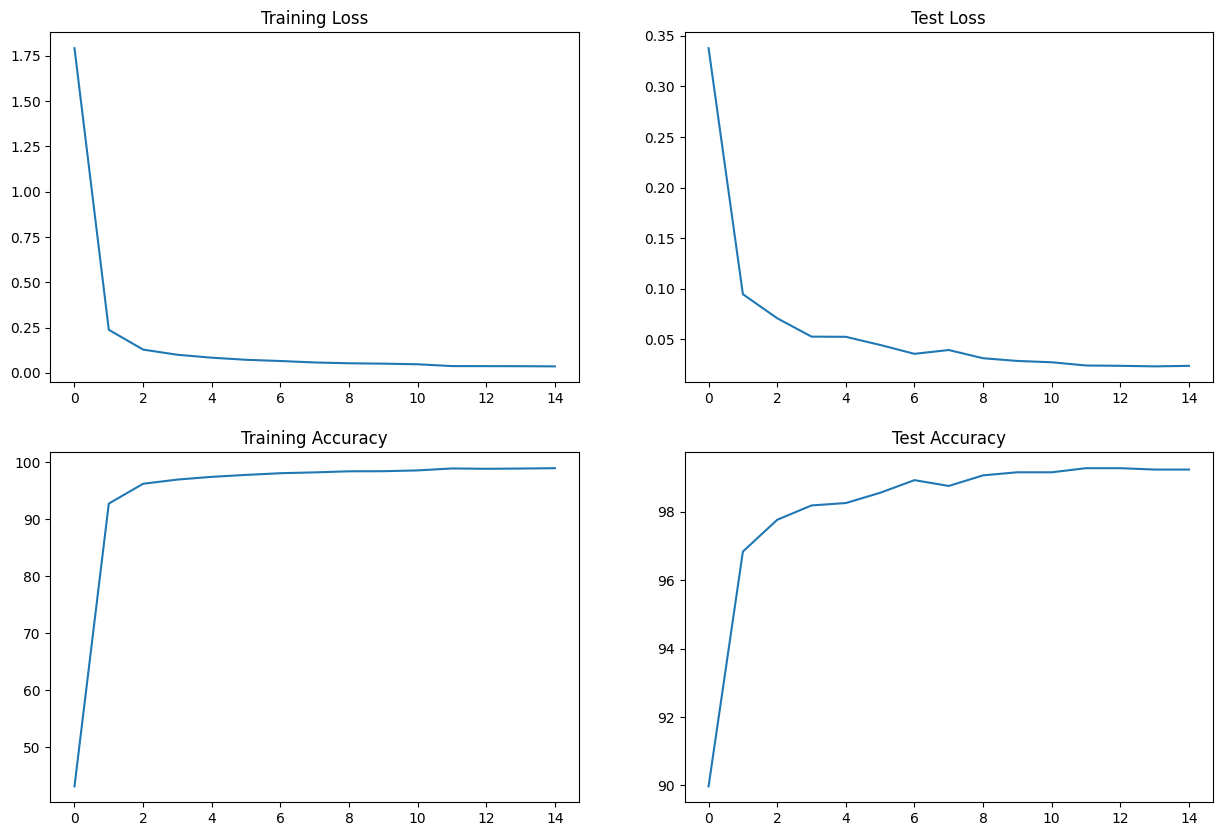

In [13]:
# CODE MOVED TO UTILS.PY

get_utilitites.plot_loss_accuracy(train_losses,train_acc,test_losses,test_acc)